# Get a vertical temperature and salinity profile somewhere in the South Atlantic (between 40 and 30 south); search for data on the web if you don’t have it already. Make a T -S plot of the data (salinity on x-axis and temperature on y-axis). Identify the significant water masses in the diagram (e.g., AABW and NADW). Compute N (z) of the profile and use this to estimate the internal Rossby radius. Note that there are packages or computing the density of sea water and other related quantities; see http://www.teos-10.org/ or some alternative source.

In [1]:
import gsw
import netCDF4 as nc
import xarray as xr
import dask.array as da
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy

from contextlib import contextmanager

@contextmanager
def usetex(enable=True):
    try:
        if enable:
            plt.rc("text", usetex=True)
        yield
    finally:
        if enable:
            plt.rc("text", usetex=False)

## Load data

In [2]:
%matplotlib inline
ds = xr.open_mfdataset(("soda_35s_30w_pt.nc", "soda_35s_30w_sal.nc"), engine="netcdf4", combine="by_coords")
ds = ds.squeeze("LONN59_N59").squeeze("LAT81_81").dropna("LEV")

In [3]:
df = ds.mean("bnds").to_dataframe()
df["LOG_LEV"] = np.log10(df.LEV_bnds)
df.head()

LONN59_N59  LAT81_81  LEV_bnds       SALT       TEMP  \
LEV     TIME                                                               
5.03355 2006-01-15      -29.75    -34.75   5.03355  35.510761  20.574379   
        2006-02-15      -29.75    -34.75   5.03355  35.500595  21.005154   
        2006-03-15      -29.75    -34.75   5.03355  35.546333  20.765606   
        2006-04-15      -29.75    -34.75   5.03355  35.575493  20.462450   
        2006-05-15      -29.75    -34.75   5.03355  35.604027  18.741344   

                     LOG_LEV  
LEV     TIME                  
5.03355 2006-01-15  0.701874  
        2006-02-15  0.701874  
        2006-03-15  0.701874  
        2006-04-15  0.701874  
        2006-05-15  0.701874

In [4]:
ds_mean = ds.mean("TIME").mean("bnds").rename({"LEV_bnds": "LEVEL"}).dropna("LEV")

## Derived values

In [5]:
def assign(dset, key, value):
    darray = xr.DataArray(value, coords=(dset.LEV,), dims=("LEV",))
    return dset.assign({key: darray})

In [6]:
g = 9.81
p_ref = 0
rho_0 = 1027  # kg / m3

ds_mean = assign(ds_mean, "z", -ds_mean.LEVEL)
ds_mean = assign(ds_mean, "p", gsw.p_from_z(ds_mean.z, ds_mean.LAT81_81))
ds_mean = assign(ds_mean, "SA", gsw.SA_from_SP(ds_mean.SALT, ds_mean.p, ds_mean.LONN59_N59, ds_mean.LAT81_81))
ds_mean = assign(ds_mean, "CT", gsw.CT_from_t(ds_mean.SA, ds_mean.TEMP, ds_mean.p))
ds_mean = assign(ds_mean, "rho", gsw.rho(ds_mean.SA, ds_mean.CT, ds_mean.p))

# pot_rho = gsw.pot_rho_t_exact(ds_mean.SA, ds_mean.TEMP, ds_mean.p, 0)
# cs2 = rho_0 * g * ds_mean.z / (pot_rho - ds_mean.rho)
# N2 = -g * (g / ds_mean.cs ** 2 + ds_mean.drho_dz / ds_mean.rho)

ds_mean = assign(ds_mean, "cs", gsw.sound_speed_t_exact(ds_mean.SA, ds_mean.TEMP, ds_mean.p)) 
ds_mean = assign(ds_mean, "drho_dz", np.gradient(ds_mean.rho) / np.gradient(ds_mean.z))
# ds_mean = assign(ds_mean, "N", N2**0.5)

LOG_LEV = r"$\log(|z|)$"
ds_mean = assign(ds_mean, LOG_LEV, da.log10(ds_mean.LEVEL))
ds_mean

<xarray.Dataset>
Dimensions:      (LEV: 44)
Coordinates:
    LONN59_N59   float64 -29.75
    LAT81_81     float64 -34.75
  * LEV          (LEV) float64 5.034 15.1 25.22 ... 3.927e+03 4.136e+03
Data variables:
    LEVEL        (LEV) float64 dask.array<shape=(44,), chunksize=(44,)>
    SALT         (LEV) float32 dask.array<shape=(44,), chunksize=(44,)>
    TEMP         (LEV) float32 dask.array<shape=(44,), chunksize=(44,)>
    z            (LEV) float64 -5.034 -15.11 -25.22 ... -3.927e+03 -4.136e+03
    p            (LEV) float64 5.07 15.22 25.41 ... 3.992e+03 4.207e+03
    SA           (LEV) float64 35.66 35.68 35.68 35.7 ... 35.0 34.97 34.95 34.95
    CT           (LEV) float64 18.25 18.13 17.98 17.74 ... 1.046 0.786 0.7568
    rho          (LEV) float64 1.026e+03 1.026e+03 ... 1.046e+03 1.047e+03
    cs           (LEV) float64 1.517e+03 1.517e+03 ... 1.52e+03 1.524e+03
    drho_dz      (LEV) float64 -0.008239 -0.008577 ... -0.004517 -0.004455
    $\log(|z|)$  (LEV) float64 0.7019 1.17

## Results

### Instantaneous T-S plot with the scatter markers shaded by $\log_{10}(z)$

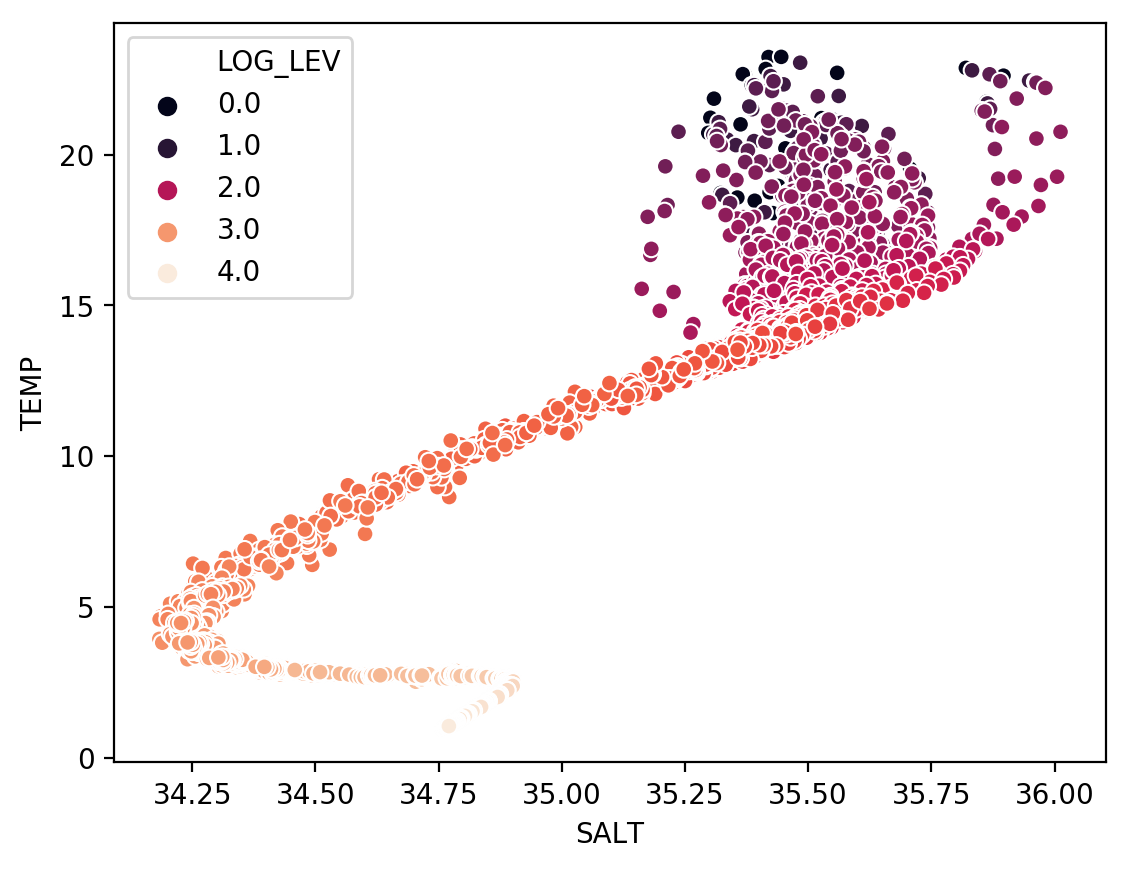

In [7]:
%matplotlib inline
sns.scatterplot("SALT", "TEMP", hue="LOG_LEV", data=df, palette="rocket")

### Time averaged T-S plot

In [8]:
SA_mesh, CT_mesh = np.meshgrid(ds_mean.SA, ds_mean.CT)
rho_mesh = gsw.rho(SA_mesh, CT_mesh, 3500)

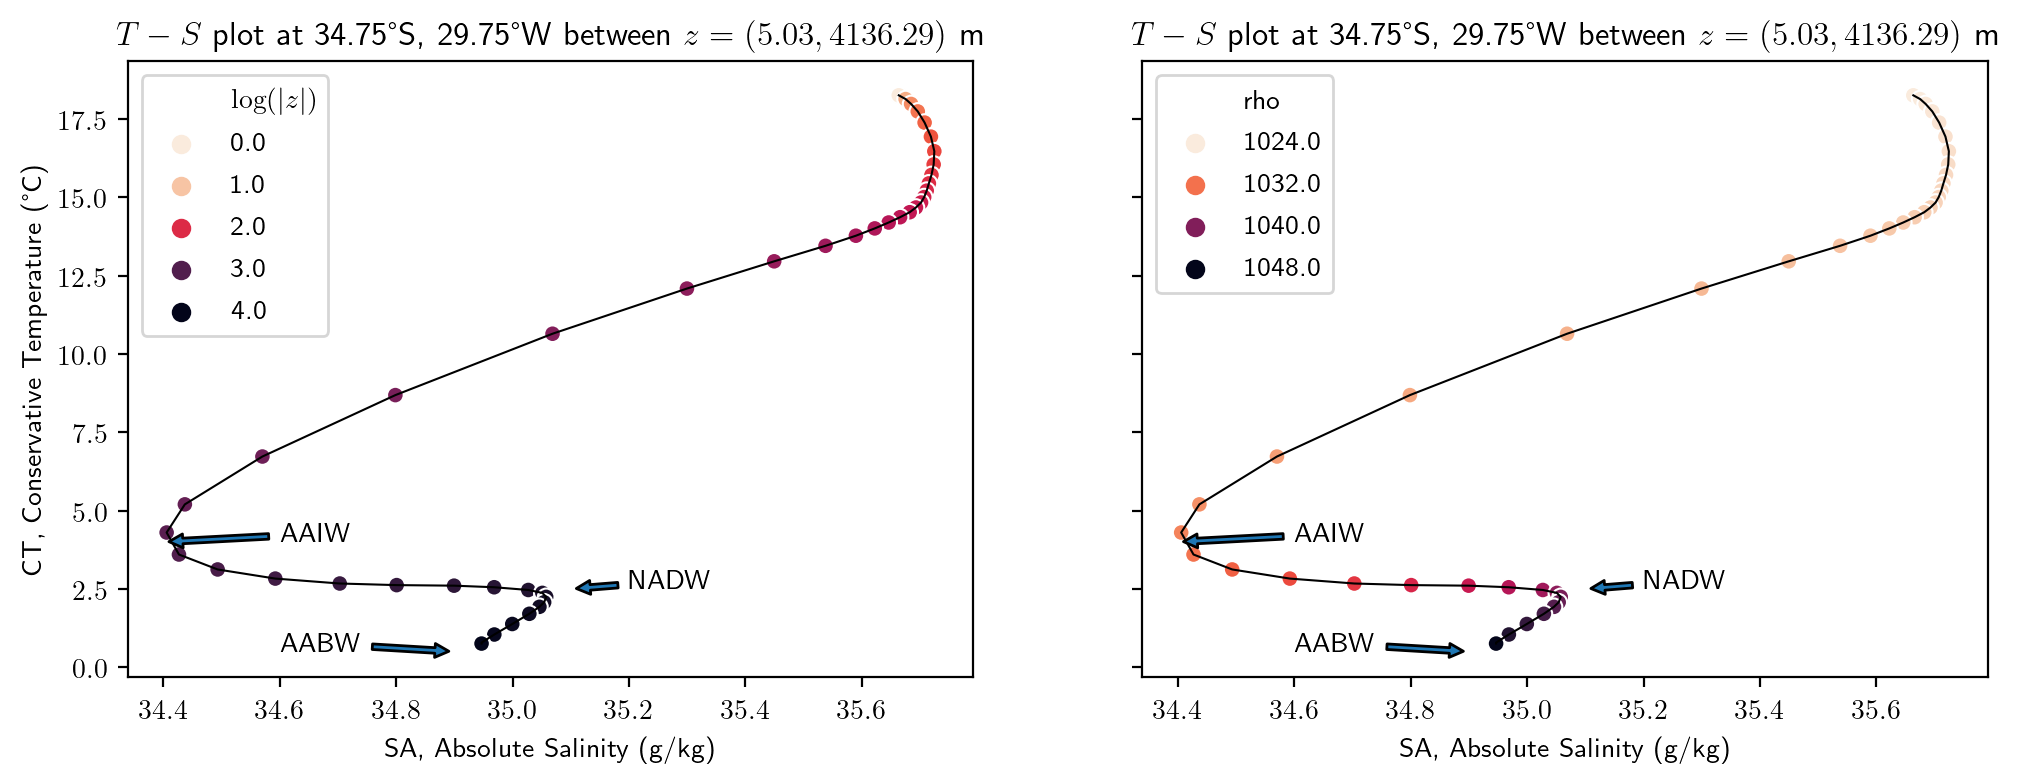

In [9]:
arrowprops = dict(arrowstyle="simple")
with usetex():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)
    sns.scatterplot("SA", "CT", hue=LOG_LEV, palette="rocket_r", data=ds_mean, ax=axes[0])
    sns.scatterplot("SA", "CT", hue="rho", palette="rocket_r", data=ds_mean, ax=axes[1])
    for ax in axes:
        ax.plot("SA", "CT", "k", linewidth=0.75, data=ds_mean)
        # ax.contour(SA_mesh, CT_mesh, rho_mesh)
        ax.set_title(f"$T-S$ plot at {-ds_mean.LAT81_81.values}°S, {-ds_mean.LONN59_N59.values}°W between $z=({ds_mean.LEVEL.min().values:.2f},{ds_mean.LEVEL.max().values:.2f})$ m")
        ax.set_xlabel("SA, Absolute Salinity (g/kg)")
        ax.set_ylabel("CT, Conservative Temperature (°C)")
        ax.annotate("AAIW", (34.4, 4),  (34.6, 4), arrowprops=arrowprops)
        ax.annotate("NADW", (35.1, 2.5),  (35.2, 2.5), arrowprops=arrowprops)
        ax.annotate("AABW", (34.9, 0.5),  (34.6, 0.5), arrowprops=arrowprops)

The water masses are identified by comparing with salinity values in the following figure:

$AAIW \approx 34.4,\, NADW \approx 35.1,\, AABW \approx 34.8$ g/kg

![](atlantic.jpeg)

### Brunt Vaisala frequency and Rossby radius

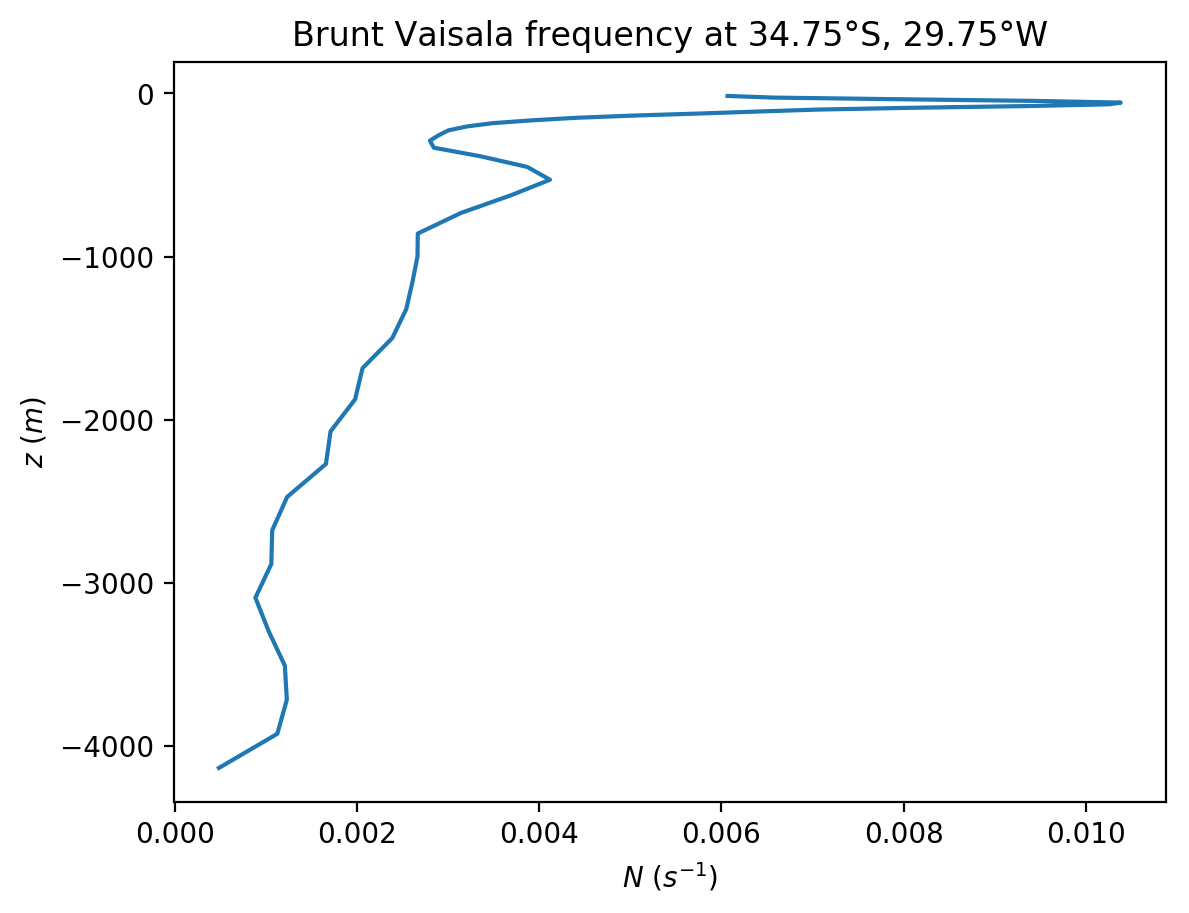

In [10]:
N2, _ = gsw.Nsquared(ds_mean.SA, ds_mean.CT, ds_mean.p, ds_mean.LAT81_81)
N = np.array(N2**0.5)
z = (ds_mean.z + ds_mean.z[1:]) / 2

with usetex(False):
    fig, ax = plt.subplots()
    ax.plot(N, z)
    ax.set_title("Brunt Vaisala frequency at " + f"{-ds_mean.LAT81_81.values}°S, {-ds_mean.LONN59_N59.values}°W")
    ax.set_xlabel(r"$N\ (s^{-1})$")
    ax.set_ylabel(r"$z\ (m)$")

Coriolis frequency at the latitude:

In [11]:
float(ds_mean.LAT81_81)

-34.75

In [12]:
f = gsw.f(ds_mean.LAT81_81)
print(f, "rad/s")

-8.31296388495988e-05 rad/s


Internal Rossby radius of deformation can be computed by integrating:

$$L_d = \frac{1}{\Pi f} \int N dz$$

In [13]:
Ld = scipy.integrate.trapz(-z, N, z[0] - z[1]) / np.pi / f
print(Ld, "m")

25616.31866504686 m


Therefore $L_d \approx 25.62$ km.